# environment

## define opponent

In [8]:
import gym
import numpy as np
import time
import yaml
import gym
import numpy as np
from scipy.spatial.distance import cdist


class F110RaceEnv(gym.Env):
    def __init__(self, env_config,
                 test_map_name=None,
                 scan_range=10.0,
                 max_v=12.0,
                 n_cps = 200,
                 cp_reward = 0.1,
                 min_cp_dist=3.0,
                 maps_path='../maps',
                 models_path='../checkpoints',
                 train_map_name='SILVERSTONE_TRAIN',
                 safe_padding=0.3,
                 laps = 1.0,
                 opponent=op_agent
                ):
        
        self.laps = laps
        self.maps_path = maps_path
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(222,), dtype=np.float32)
        self.max_v = max_v
        self.test_map_name = test_map_name
        self.min_cp_dist = min_cp_dist
        self.n_cps = n_cps
        self.cp_reward = cp_reward
        self.scan_range = scan_range
        self.safe_padding = safe_padding
        self.map_path = None
        self.train_map_name = train_map_name
        self.action_space = gym.spaces.Box(low=-1, high=1, shape=(2,), dtype=np.float32)
        self.cum_r = 0
        self.prev_vel = [4.0] * 100
        self.total_padding_punish = 0
        self.opponent = opponent
        self.prev_state = None
    
    def _render_callback(self, env_renderer):
        # custom extra drawing function

        e = env_renderer

        # update camera to follow car
        x = e.cars[0].vertices[::2]
        y = e.cars[0].vertices[1::2]
        top, bottom, left, right = max(y), min(y), min(x), max(x)
        e.score_label.x = left
        e.score_label.y = top - 700
        e.left = left - 800
        e.right = right + 800
        e.top = top + 800
        e.bottom = bottom - 800
  
    def load_train_setup(self):
        no = np.random.choice([1, 2, 3])
        
        map_path = f"{self.maps_path}/{self.train_map_name}{no}"
        with open(f'{self.maps_path}/ss{no}-wp.np', 'rb') as f:
            wps = np.load(f)
            
        return map_path, wps
    
    def load_test_setup(self):
        map_path = f"{self.maps_path}/{self.test_map_name}"
        with open(f'{self.maps_path}/ss-wp.np', 'rb') as f:
            wps = np.load(f)
            
        return map_path, wps

    def build_checkpoints(self, wps, cp_dist):
        
        start = np.random.randint(0, len(wps)-1)
        checkpoints = []
        
        i = 0
        while i < len(wps):
            if i % cp_dist == 0:
                checkpoints.append(wps[(start+i)%len(wps)])
            i += 1
        return checkpoints
    
    def reset(self):
        self.prev_vel = [4.0] * 100
        self.total_padding_punish = 0
        self.cum_r = 0
        
        if self.test_map_name is not None:
            map_path, wps = self.load_test_setup()
        else:
            map_path, wps = self.load_train_setup()
        
#         print(map_path, len(wps))
        self.map_path = map_path
        self.env = gym.make('f110_gym:f110-v0', map=map_path, map_ext='.png', num_agents=2)
        self.env.add_render_callback(self._render_callback)
        
        cp_dist = len(wps)//self.n_cps
        
        self.checkpoints = self.build_checkpoints(wps, cp_dist)
#         print(f"number of checkpoints: {len(self.checkpoints)}")
        
        if self.test_map_name is None:
#             start_idx = np.random.randint(0, len(self.checkpoints))
#             start_point = self.checkpoints[start_idx]
            
            dists = cdist([[0,0]], np.array(self.checkpoints)[:,:2])
            start_idx = np.argmin(dists)
            start_point = [0., 0., np.pi+1]
            
        else:
            dists = cdist([[0,0]], np.array(self.checkpoints)[:,:2])
            start_idx = np.argmin(dists)
            start_point = [3., 3., np.pi+1]
            
        self.next_cp_idx = (start_idx + 2)%len(self.checkpoints)
            
        op_start_point = [0.0, 0.0, np.pi+1]
        
        obs, step_reward, done, info = self.env.reset(
            np.array([
                start_point,
                op_start_point
            ])
        )
        
        self.t = 0
        self.prev_state = self.to_vector_state_op(obs) 
        return self.prev_state
    
    def to_vector_state(self, obs):
        
        scanner = np.clip(obs['scans'][0], 0, self.scan_range)
        scanner = scanner[3*70:3*290]
        buck = 3
        size = len(scanner)//buck
        agg_scanner = np.zeros(size,)
        for i in range(size):
            agg_scanner[i] = np.min(scanner[i*buck: i*buck+buck])
        
        agg_scanner /= self.scan_range
        state = np.concatenate([
            agg_scanner,
            np.array(obs['linear_vels_x'][:1])/self.max_v,
            np.array(obs['ang_vels_z'][:1])/self.max_v,
        ])
        
        return state
    
    def to_vector_state_op(self, obs):

        scanner = np.clip(obs['scans'][1], 0, self.scan_range)
        scanner = scanner[3*70:3*290]
        buck = 3
        size = len(scanner)//buck
        agg_scanner = np.zeros(size,)
        for i in range(size):
            agg_scanner[i] = np.min(scanner[i*buck: i*buck+buck])

        agg_scanner /= self.scan_range
        state = np.concatenate([
            agg_scanner,
            np.array(obs['linear_vels_x'][1:])/self.max_v,
            np.array(obs['ang_vels_z'][1:])/self.max_v,
        ])

        return state

    def checkpoint(self, position):
        return_cp_idx = (self.next_cp_idx - 10)%len(self.checkpoints)
        return_dist = np.linalg.norm(position - self.checkpoints[return_cp_idx][:2])
        dist = np.linalg.norm(position - self.checkpoints[self.next_cp_idx][:2])
        reward = 0
        if dist < self.min_cp_dist:
            reward = self.cp_reward
            self.next_cp_idx = (self.next_cp_idx + 1)%len(self.checkpoints)
        elif return_dist < 3.0:
            reward = -1
        return reward
        
        
    def step(self, action):
        reward = 0

        act_v = action[0]*(self.max_v/2)+(self.max_v/2)
        self.prev_vel.insert(0, act_v)
        self.prev_vel.pop()
        th = action[1]*np.pi/6
        
        op_act = self.opponent.compute_single_action(self.prev_state, explore=False)
        op_v = op_act[0]*(self.max_v/2)+(self.max_v/2)
        op_th = op_act[1]*np.pi/6
        
        act = np.array([[th, act_v], [op_th, op_v]])

        obs, step_reward, done, info = self.env.step(act)
        pose_x = obs['poses_x'][0]
        pose_y = obs['poses_y'][0]
        
        next_state = self.to_vector_state(obs)
        self.prev_state = self.to_vector_state_op(obs)
        
        position = np.array([pose_x, pose_y])

        if obs['collisions'][0] == 1.0:
            reward = -1
            done = True
            if self.test_map_name is not None:
                print('CRASHED')
            return next_state, reward, done, {}
            
        cp_reward = self.checkpoint(position)
        reward += cp_reward
        self.t += 1
        
        if obs['lap_counts'][0] == self.laps or obs['lap_counts'][1] == self.laps:
            ego_t = obs['lap_times'][0]  
            op_t = obs['lap_times'][0]
            
            if obs['lap_counts'][1] == self.laps:
                reward = -1
                print(f"op agent win! on {self.map_path} got reward {self.cum_r} in {ego_t}. Finish reward: {reward}. Padding punish: {self.total_padding_punish}")
            
            else:
                reward = +1
                print(f"ego agent win! on {self.map_path} got reward {self.cum_r} in {ego_t}. Finish reward: {reward}. Padding punish: {self.total_padding_punish}")
            
            done = True
        elif cp_reward == -1:
            t = obs['lap_times'][0]
            print(f"agent on {self.map_path} got reward {self.cum_r} in {t}. RETURNED")
            done = True
        elif np.max(self.prev_vel)<3.0:
            t = obs['lap_times'][0]
            print(f"agent on {self.map_path} got reward {self.cum_r} in {t}. STOPPED")
            reward = -1
            done = True
        
        if done and self.test_map_name is not None:
            print('lap:', obs['lap_times'])
        
        if np.min(obs['scans'][0]) < self.safe_padding:
            reward += -0.05
            self.total_padding_punish -= 0.05
        
        self.cum_r += reward
        return next_state, reward, done, {'pos': position}
    
    def render(self):
        self.env.render()

e = F110RaceEnv({})
e.reset()

array([0.01564346, 0.01567272, 0.01570479, 0.01573967, 0.01577742,
       0.01581805, 0.01586161, 0.01590813, 0.01595766, 0.01601024,
       0.01606592, 0.01612475, 0.01618679, 0.01625209, 0.01632073,
       0.01639275, 0.01646824, 0.01654726, 0.0166299 , 0.01671624,
       0.01680637, 0.01690037, 0.01699835, 0.01710041, 0.01720666,
       0.01731721, 0.01743219, 0.01755173, 0.01767595, 0.01780501,
       0.01793905, 0.01807823, 0.01822273, 0.01837271, 0.01852838,
       0.01868993, 0.01885757, 0.01903152, 0.01921202, 0.01939932,
       0.01959369, 0.01979541, 0.02000477, 0.0202221 , 0.02044774,
       0.02068204, 0.02092539, 0.02117819, 0.02144088, 0.02171392,
       0.02199781, 0.02229308, 0.02260029, 0.02292006, 0.02325304,
       0.02359992, 0.02396147, 0.02433848, 0.02473184, 0.02514248,
       0.02557143, 0.0260198 , 0.02648877, 0.02697965, 0.02749385,
       0.02803291, 0.02859851, 0.02919249, 0.02981687, 0.03047386,
       0.0311659 , 0.03189567, 0.03266614, 0.0325703 , 0.03235

# training

In [7]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [13]:
%%time

import ray
from ray.rllib.agents import ppo
from ray.rllib.agents.ppo.ppo import DEFAULT_CONFIG
import gym
import numpy as np

# with half cheeta configs

ray.shutdown()
ray.init()

hc_configs = {
    'framework': 'torch',
    'num_workers': 15,
    'gamma': 0.99,
    'num_gpus': 1.0,
    'kl_coeff': 1.0,
    'clip_param': 0.2,
    'model': {
        'fcnet_hiddens': [300, 300, 300],
    },
    'num_envs_per_worker': 1,
    'train_batch_size': 100000,
    'sgd_minibatch_size': 4096,
    'batch_mode': 'truncate_episodes',
    'lr': .0003,
}

trainer = ppo.PPOTrainer(env=F110RaceEnv, config=hc_configs)
# print("FINE TUNING")
trainer.restore('../checkpoints/v2.2/checkpoint_000031/checkpoint-31')


2022-04-13 17:07:51,050	WARNING deprecation.py:45 -- DeprecationWarning: `clear_buffer` has been deprecated. Use `Filter.reset_buffer()` instead. This will raise an error in the future!


AttributeError: 'PPOTrainer' object has no attribute 'local_replay_buffer'

In [12]:

print(trainer.config)
rewards = []
best_reward = -100
models_path = '../checkpoints'

import pickle

for i in range(300):
    result = trainer.train()
    episode_r = result['episode_reward_mean']
    print(f"episode: {i} reward:{episode_r}")
    rewards.append(episode_r)
    with open(f'{models_path}/race_v1.0_r', 'wb') as f:
        pickle.dump(rewards, f)
        
    if i%5 == 0 and episode_r > best_reward:
        best_reward = episode_r
        cp = trainer.save(f"{models_path}/race_v1.0")
        print("checkpoint saved at", cp)


{'num_workers': 15, 'num_envs_per_worker': 1, 'create_env_on_driver': True, 'rollout_fragment_length': 6666, 'batch_mode': 'truncate_episodes', 'gamma': 0.99, 'lr': 0.0003, 'train_batch_size': 100000, 'model': {'_use_default_native_models': False, '_disable_preprocessor_api': False, 'fcnet_hiddens': [300, 300, 300], 'fcnet_activation': 'tanh', 'conv_filters': None, 'conv_activation': 'relu', 'post_fcnet_hiddens': [], 'post_fcnet_activation': 'relu', 'free_log_std': False, 'no_final_linear': False, 'vf_share_layers': False, 'use_lstm': False, 'max_seq_len': 20, 'lstm_cell_size': 256, 'lstm_use_prev_action': False, 'lstm_use_prev_reward': False, '_time_major': False, 'use_attention': False, 'attention_num_transformer_units': 1, 'attention_dim': 64, 'attention_num_heads': 1, 'attention_head_dim': 32, 'attention_memory_inference': 50, 'attention_memory_training': 50, 'attention_position_wise_mlp_dim': 32, 'attention_init_gru_gate_bias': 2.0, 'attention_use_n_prev_actions': 0, 'attention_us

2022-04-13 17:07:09,392	WARNING trainer.py:973 -- Worker crashed during call to `step_attempt()`. To try to continue training without the failed worker, set `ignore_worker_failures=True`.


RayTaskError(ValueError): [36mray::RolloutWorker.par_iter_next()[39m (pid=13956, ip=10.64.91.46, repr=<ray.rllib.evaluation.rollout_worker.RolloutWorker object at 0x2ba84691c6a0>)
  File "/projects/academic/kjoseph/navid/anaconda3/envs/py38/lib/python3.8/site-packages/ray/util/iter.py", line 1151, in par_iter_next
    return next(self.local_it)
  File "/projects/academic/kjoseph/navid/anaconda3/envs/py38/lib/python3.8/site-packages/ray/rllib/evaluation/rollout_worker.py", line 382, in gen_rollouts
    yield self.sample()
  File "/projects/academic/kjoseph/navid/anaconda3/envs/py38/lib/python3.8/site-packages/ray/rllib/evaluation/rollout_worker.py", line 753, in sample
    raise ValueError("RolloutWorker has no `input_reader` object! "
ValueError: RolloutWorker has no `input_reader` object! Cannot call `sample()`. You can try setting `create_env_on_driver` to True.

2022-04-13 17:07:15,104	ERROR worker.py:85 -- Unhandled error (suppress with RAY_IGNORE_UNHANDLED_ERRORS=1): ray::RolloutWorker.par_iter_next() (pid=13919, ip=10.64.91.46, repr=<ray.rllib.evaluation.rollout_worker.RolloutWorker object at 0x2add4aa806a0>)
  File "/projects/academic/kjoseph/navid/anaconda3/envs/py38/lib/python3.8/site-packages/ray/util/iter.py", line 1151, in par_iter_next
    return next(self.local_it)
  File "/projects/academic/kjoseph/navid/anaconda3/envs/py38/lib/python3.8/site-packages/ray/rllib/evaluation/rollout_worker.py", line 382, in gen_rollouts
    yield self.sample()
  File "/projects/academic/kjoseph/navid/anaconda3/envs/py38/lib/python3.8/site-packages/ray/rllib/evaluation/rollout_worker.py", line 753, in sample
    raise ValueError("RolloutWorker has no `input_reader` object! "
ValueError: RolloutWorker has no `input_reader` object! Cannot call `sample()`. You can try setting `create_env_on_driver` to True.
2022-04-13 17:07:15,105	ERROR worker.py:85 -- Un

2022-04-13 17:07:15,109	ERROR worker.py:85 -- Unhandled error (suppress with RAY_IGNORE_UNHANDLED_ERRORS=1): ray::RolloutWorker.par_iter_next() (pid=13931, ip=10.64.91.46, repr=<ray.rllib.evaluation.rollout_worker.RolloutWorker object at 0x2b97ce6af6a0>)
  File "/projects/academic/kjoseph/navid/anaconda3/envs/py38/lib/python3.8/site-packages/ray/util/iter.py", line 1151, in par_iter_next
    return next(self.local_it)
  File "/projects/academic/kjoseph/navid/anaconda3/envs/py38/lib/python3.8/site-packages/ray/rllib/evaluation/rollout_worker.py", line 382, in gen_rollouts
    yield self.sample()
  File "/projects/academic/kjoseph/navid/anaconda3/envs/py38/lib/python3.8/site-packages/ray/rllib/evaluation/rollout_worker.py", line 753, in sample
    raise ValueError("RolloutWorker has no `input_reader` object! "
ValueError: RolloutWorker has no `input_reader` object! Cannot call `sample()`. You can try setting `create_env_on_driver` to True.
2022-04-13 17:07:15,110	ERROR worker.py:85 -- Un

In [1]:
!rm -rf ../checkpoints/v3

# evaluation

In [4]:
import ray
from ray.rllib.agents import ppo
import gym
import numpy as np

hc_configs = {
    'framework': 'torch',
    'num_workers': 0,
    'action_space': gym.spaces.Box(low=-1, high=1, shape=(2,), dtype=np.float32),
    'observation_space': gym.spaces.Box(low=-np.inf, high=np.inf, shape=(222,), dtype=np.float32)
}

trainer = ppo.PPOTrainer(config=hc_configs)
trainer.restore('../checkpoints/v2.0/checkpoint_000061/checkpoint-61')



Install gputil for GPU system monitoring.
2022-04-13 16:19:18,849	INFO trainable.py:472 -- Restored on 10.64.91.46 from checkpoint: ../checkpoints/v2.0/checkpoint_000061/checkpoint-61
2022-04-13 16:19:18,850	INFO trainable.py:480 -- Current state after restoring: {'_iteration': 61, '_timesteps_total': 12198780, '_time_total': 2810.929140329361, '_episodes_total': 6347}


In [7]:
done = False
env = F110RaceEnv({}, test_map_name='SILVERSTONE_OBS', laps=1)
obs = env.reset()
poses = []
hist = []

r = 0
i = 0
while not done:
    i += 1
    action = trainer.compute_single_action(obs, explore=False)
    obs, reward, done, info = env.step(action)
    if 'pos' in info:
        pos = info['pos'] 
        hist.append([obs[-2], reward, done, pos])
    
    if i % 100 == 0 and len(pos)>0:
        poses.append(pos)
    r += reward
    
print(f'reward:{r}')
env.close()

# hist

UnboundLocalError: local variable 't' referenced before assignment

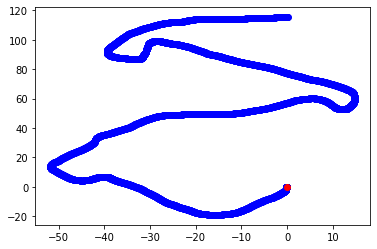

In [8]:
import matplotlib.pyplot as plt

wps = np.array([i[-1] for i in hist])
plt.scatter(wps[:,0], wps[:,1], c='b')
plt.scatter(wps[0,0], wps[0,1], c='r')

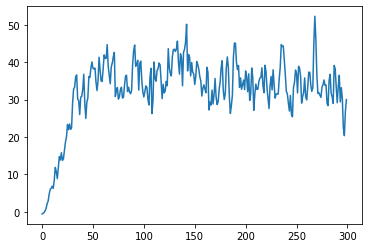

In [44]:
import matplotlib.pyplot as plt
import pickle 

with open('checkpoints/race_v1.1_r', 'rb') as f:
    rs = pickle.load(f)
    
plt.plot(rs)

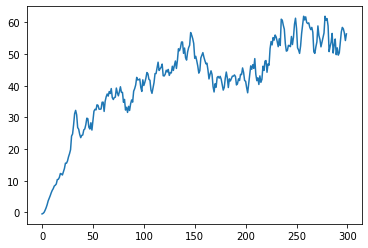

In [4]:
import matplotlib.pyplot as plt
import pickle 

with open('checkpoints/v1.2_r', 'rb') as f:
    rs = pickle.load(f)
    
plt.plot(rs)

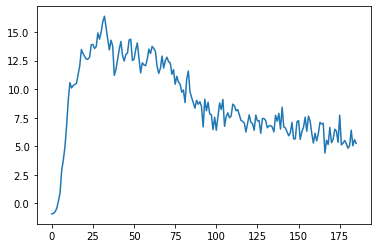

In [5]:
import matplotlib.pyplot as plt
import pickle 

with open('../checkpoints/v2.2_r', 'rb') as f:
    rs = pickle.load(f)
    
plt.plot(rs)
